## Predicting El Niño using LSTM

### 1. Introduction

El Niño is the warmth phase of the El Niño Southern Oscillation (ENSO)[1], a recurring climate pattern across the tropical pacific. The pattern can shift back and forth irregularly every two to seven years and each phase triggers predictable disruptions of temperature, precipitation and winds[2]. Due to the warm water effect El Niño produces widespread and sometimes severe changes in the climate. Particularly, in Ecuador and Northern Peru rainfall increases contributing to coastal flooding and erosion[3], which have devastating effects on the economy of those countries. 





![Flooding in Ica, Peru 2017](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c4/JMC_3208_%2832149486630%29.jpg/640px-JMC_3208_%2832149486630%29.jpg)
<h4><center>Image 1. Flooding int the city of Ica in Peru - 2017</center></h4>

In climate science, ENSO is characterized through Southern Oscillation Index (SOI), an standardized index based on the observed sea level pressure differences between Tahiti and Darwin, Australia. 

To predict El Niño we will use variables believed to be related to sea surface temperature, sea level pressure, precipitation, etc:

1. Oceanic Nino Index (ONI), a climate index used for sea surface temperature (SST).
2. Eastern Tropical Pacific SST (Nino 3), another climate index used for SST focusing on a slightly different region.
3. Pacific North American Index (PNA). PNA is a closely related phenomena to ENSO.
4. Precipitation monthly mean. Historical global precipitation monthly mean in raster format and vector values.

### 2. Exploratory Analysis

We will start by reading the dataset and observing the variables

In [1]:
%matplotlib inline

# I'll be putting the functions in the order they appear
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

df = pd.read_csv('Data.csv')
df.head()

,date,soi,oni,nino3,pna,precip
0,195101,1.5,-0.8,-0.72,-1.18,NaN
1,195102,0.9,-0.5,-0.43,-2.11,NaN
2,195103,-0.1,-0.2,-0.63,-1.09,NaN
3,195104,-0.3,0.2,0.00,0.47,NaN
4,195105,-0.7,0.4,-0.12,1.19,NaN


As we can see, the date doesn't have a typical datetime structure, while the other variables are numeric. Let's see the description of the variables:

In [2]:
df.describe()

,date,soi,oni,nino3,pna,precip
count,800.000000,800.000000,800.000000,800.000000,800.000000,464.000000
mean,198389.980000,0.124750,0.041000,-0.063712,-0.095113,0.006940
std,1925.744686,0.945664,0.833539,0.866545,1.029225,3.611202
min,195101.000000,-3.600000,-2.000000,-2.080000,-3.190000,-5.690000
25%,196708.750000,-0.500000,-0.500000,-0.655000,-0.750000,-2.092500
50%,198404.500000,0.100000,0.000000,-0.150000,-0.075000,-0.800000
75%,200034.250000,0.800000,0.600000,0.370000,0.600000,1.072500
max,201708.000000,2.900000,2.600000,3.240000,2.870000,15.430000


We see that there are 800 observations but precipitation has 464, and we confirm that the date variable is a numeric too, so it requires to be parsed to a datetime format. 

In [3]:
# Create a function to convert parse the date variable
def parser(x):
    if str(x).endswith('10') or str(x).endswith('11') or str(x).endswith('12'):
        return datetime.strptime(str(x),'%Y%m')
    else:
        return datetime.strptime(str(x),'%Y0%m')

df['date'] = df['date'].apply(parser)

# And now convert date to index
df = df.set_index('date')


In [4]:
df.head()

,soi,oni,nino3,pna,precip
date,,,,,
1951-01-01,1.5,-0.8,-0.72,-1.18,NaN
1951-02-01,0.9,-0.5,-0.43,-2.11,NaN
1951-03-01,-0.1,-0.2,-0.63,-1.09,NaN
1951-04-01,-0.3,0.2,0.00,0.47,NaN
1951-05-01,-0.7,0.4,-0.12,1.19,NaN


In [5]:
# We are going to use data from 1979, and standardize the value
start = 336
df = df.iloc[start:]
df = (df - df.mean())/df.std()
df.head()

,soi,oni,nino3,pna,precip
date,,,,,
1979-01-01,-0.441750,-0.059963,-0.150376,-1.537109,1.424196
1979-02-01,0.997371,0.056451,-0.271512,-2.725606,0.200227
1979-03-01,0.072222,0.172865,-0.139364,0.080846,-0.530831
1979-04-01,-0.133367,0.289280,0.213033,-0.148864,-0.755133
1979-05-01,0.483399,0.172865,0.036835,1.269344,-0.270530


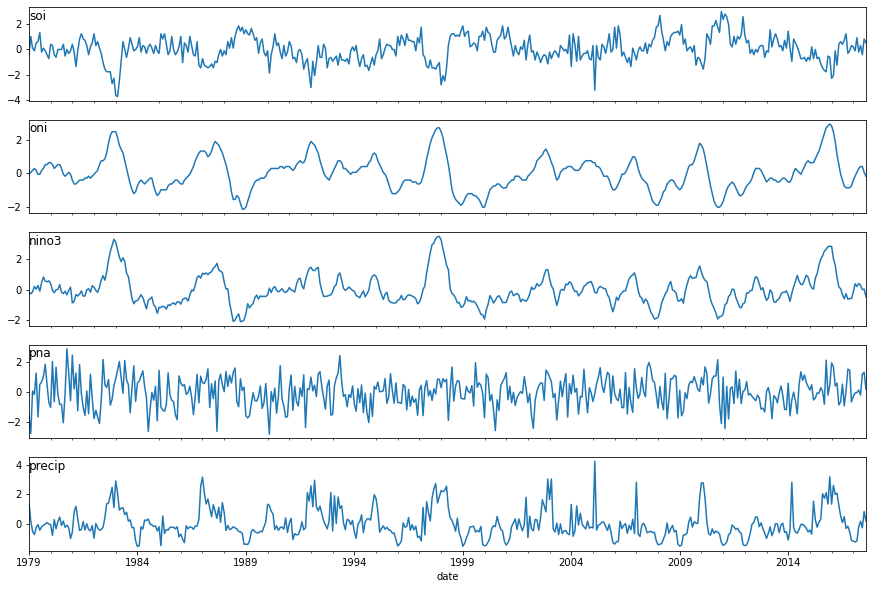

In [6]:
# Now we can plot each variable
i = 1
fig = plt.figure(figsize=(15,10))
for col in df.columns.tolist():
    fig.add_subplot(len(df.columns.tolist()),1,i)
    df[col].plot()
    plt.title(col, y = 0.8, loc = 'left')
    if i!=len(df.columns.tolist()):
        plt.tick_params(
            axis = 'x',
            bottom = False, 
            top = False,
            labelbottom=False)
        plt.xlabel('')
    i+=1
    
plt.show()   


### 3. Correlation Analysis

In [7]:
from skimage import io
import math
from scipy.stats.stats import pearsonr
from numpy import unravel_index

In [8]:
precip_full = io.imread('Precipitation.tif')
precip_full.shape


(72, 144, 466)

We see that the raster data has 466 months represented. We have to remember that the csv data has only 464 observations.

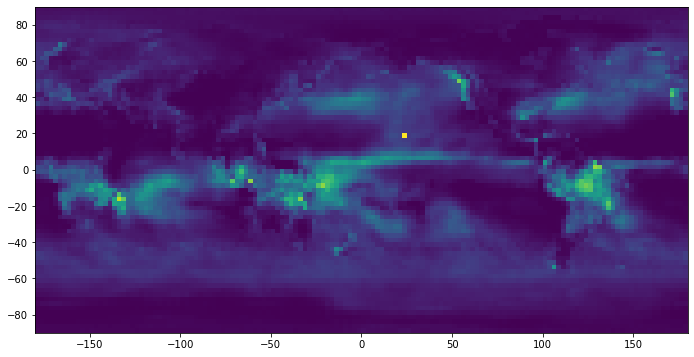

In [9]:
plt.figure(figsize = (15,6))
plt.imshow(precip_full[:,:,1], extent=[-180,180,-90,90])
plt.show()
# You'll see on the plot the world continents. 
# On the right you can see South America, which has greener colors by Peru and Brazil zone
# Peru is near coordinates 100,0

In [10]:
# Calculate historical mean for each month
# Consider that we have 466 months, almost 39 years. 
a = np.zeros(shape = (precip_full.shape[0], precip_full.shape[1], math.ceil(precip_full.shape[2]/12)*12))
# In a zero array reshaped to 39 years, we will copy the data of precipitation
a[:,:, 0:precip_full.shape[2]] = precip_full
# Then, we will reshape the array to add a new dimension, the month
a = a.reshape(a.shape[0],a.shape[1],int(a.shape[2]/12),12)
# On the third axis, we will sum values for each month
monthly_sum = np.sum(a, axis = 2)

# We have all months for 39 years from January to October, so let's calculate the mean
monthly_mean_jan_oct = monthly_sum[:,:,0:10]/a.shape[2]
# But we only have 38 years for November and december
monthly_mean_nov_dec = monthly_sum[:,:,-2:]/(a.shape[2]-1)
# And then, we join the means calculated
monthly_mean = np.append(monthly_mean_jan_oct, monthly_mean_nov_dec, axis = 2)

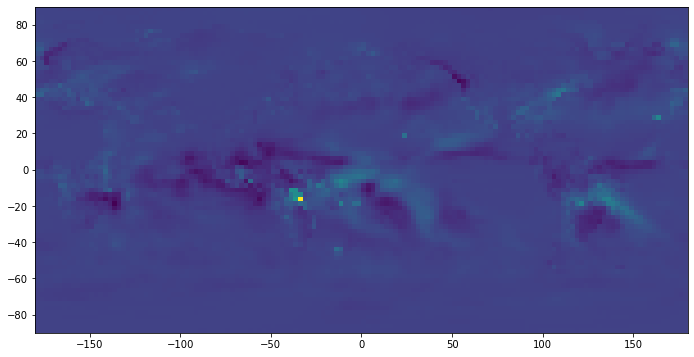

In [11]:
# Now, we calculate the difference
for i in range(a.shape[3]):
    a[:,:,i,:]-=monthly_mean

# Let's reshape the data
a = a.reshape(a.shape[0], a.shape[1], a.shape[2]*a.shape[3])

# Now we plot the differences per month
plt.figure(figsize =(15,6))
plt.imshow(a[:,:,0], extent =[-180,180,-90,90])
plt.show()

5
(72, 144, 459)


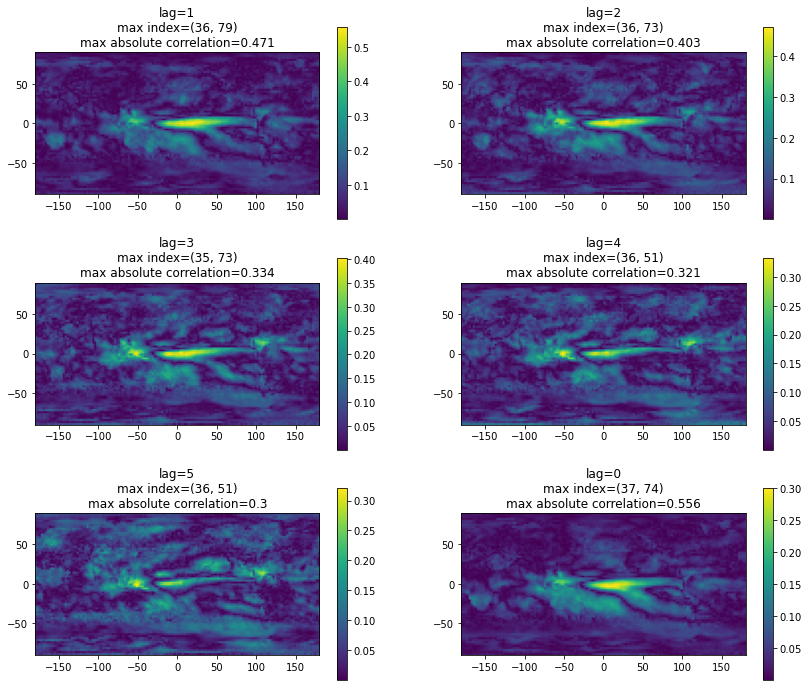

In [12]:
lag = 5
fig, axs = plt.subplots(nrows = 3, ncols = 2, figsize = (14,12))
for t in range(lag+1):
    soi = df.values[t:,0]
    soi = soi.reshape(soi.shape[0],1)
    precip = a[:,:,0:-4-t]
    r2 = []
    for i in range(precip.shape[0]):
        for j in range(precip.shape[1]):
            # Pearson R only accepts array-like inputs. I.e. ([1,2]) instead of ([[1,2]]). That's why we reshape
            r2_index, r2_pvalue = pearsonr(soi.reshape(soi.shape[0]), precip[i,j,:].reshape(precip.shape[2]))
            r2.append(r2_index)
    
    r2_map = np.array(r2).reshape(precip.shape[0],precip.shape[1])
    max_index = unravel_index(r2_map.argmax(),r2_map.shape)
    im = axs.flat[t-1].imshow(np.abs(r2_map),extent=[-180,+180,-90,+90])
    fig.colorbar(im,ax=axs[t//2,t%2])
    
    # Now we want the absolute correlation
    r2_map = np.abs(r2_map)
    max_index = unravel_index(r2_map.argmax(),r2_map.shape)
    axs.flat[t-1].set_title('lag=' + str(t) + '\n' + 'max index=' + 
                            str(max_index) + '\n' + 'max absolute correlation=' + 
                            str(float("%.3f" % r2_map[max_index])))
print(t)
print(precip.shape)